In [219]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score,classification_report
import joblib

In [220]:
dataset=pd.read_csv("googleplaystore.csv")
dataset.drop_duplicates(inplace=True)
dataset=dataset[dataset["Category"]!="1.9"]
dataset.dropna(subset=["Rating"],inplace=True)
dataset["Reviews"]=dataset["Reviews"].astype(int)

In [221]:
def size_convert(size):
    if size.endswith("M"):
        return float(size.replace("M",""))
    elif size.endswith("k"):
        return float(size.replace("k",""))/1000
    else:
        return np.nan
dataset["Size"]=dataset["Size"].apply(size_convert)
dataset.fillna(dataset['Size'].median(),inplace=True)

    

In [222]:

dataset["Installs"]=dataset["Installs"].str.replace(",","").str.replace("+","").astype(int)


In [223]:
dataset['Price']=dataset['Price'].str.replace("$","").astype(float)

In [224]:

dataset['Last Updated']=pd.to_datetime(dataset['Last Updated'],errors='coerce')
dataset['update_month']=dataset['Last Updated'].dt.month

dataset['month_sin']=np.sin(2*np.pi*dataset["update_month"]/12)
dataset['month_cos']=np.cos(2*np.pi*dataset["update_month"]/12)

In [225]:

top_categories = dataset["Category"].value_counts().nlargest(10).index
dataset["Category_grouped"] = dataset["Category"].apply(lambda x: x if x in top_categories else "other")

dataset[["primary_genre","secondary_genre"]]=dataset["Genres"].str.split(";",expand=True).fillna("None")
top_genres=dataset["primary_genre"].value_counts().nlargest(10).index
dataset['primary_genre_grouped']=dataset['primary_genre'].apply(lambda x:x if x in top_genres else 'other')

In [226]:
rating_group_map = {
    "Everyone": "Everyone",
    "Everyone 10+": "Upto 18",
    "Teen": "Upto 18",
    "Mature 17+": "Upto 18",
    "Adults only 18+": "Above 18",
    "Unrated": "Unrated"
}

dataset["Content_Rating_Grouped"] = dataset["Content Rating"].map(rating_group_map)

In [227]:
dataset['review_density']=dataset["Reviews"]/(dataset["Size"]+1e-5)
dataset["install_to_review"]=dataset["Installs"]/(dataset["Reviews"]+1e-5)
dataset['update_angle']=np.arctan2(dataset["month_sin"],dataset["month_cos"])


In [228]:
dataset['is_paid']=dataset["Type"].apply(lambda x: 1 if x=="paid" else 0)

dataset.drop(columns=["App", "Category", "primary_genre", "secondary_genre", "Genres","Last Updated", "Content Rating", "update_month", "Type", "Price","Current Ver", "Android Ver"],inplace=True)

In [229]:
x=dataset.drop(columns=["Rating"])
y=dataset["Rating"]

y_class=pd.cut(y,bins=[0,4.0,5.0],labels=["Low","High"])
y_ord=y_class.map({"Low":0,"High":1})

In [230]:
X_train,X_test,y_train,y_test=train_test_split(x,y_ord,test_size=0.20,random_state=42)

In [231]:
X_train.columns

Index(['Reviews', 'Size', 'Installs', 'month_sin', 'month_cos',
       'Category_grouped', 'primary_genre_grouped', 'Content_Rating_Grouped',
       'review_density', 'install_to_review', 'update_angle', 'is_paid'],
      dtype='object')

In [232]:
cat_cols = ["Category_grouped", "primary_genre_grouped", "Content_Rating_Grouped"]
num_cols = ["Reviews", "Size", "Installs", "month_sin", "month_cos","review_density", "install_to_review", "update_angle"]
passthrough_cols = ["is_paid"]

In [233]:
preprocessor=ColumnTransformer(transformers=[
    ("target_encoder",TargetEncoder(),cat_cols),
    ('scaler',PowerTransformer(),num_cols),
    ('passthrough',"passthrough",passthrough_cols),
    ])

In [234]:
rf=RandomForestClassifier(
    n_estimators= 250,
    max_depth= None,
    min_samples_split= 5,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    bootstrap= True,
    class_weight= None)

cat=CatBoostClassifier(iterations= 851,
    learning_rate= 0.14090806071066586,
    depth= 9,
    l2_leaf_reg= 1.6276602969353386,
    border_count= 203,
    bagging_temperature= 0.20726177267535123,
    random_strength= 0.6973589737716657,
    grow_policy= 'SymmetricTree')

xgb=XGBClassifier(
    n_estimators= 210,
    learning_rate= 0.09,
    max_depth=6,
    min_child_weight= 1,
    subsample= 0.8,
    colsample_bytree= 0.8,
    gamma= 0.4,
    reg_alpha= 0.1,
    reg_lambda= 1.789924170017799,
    eval_metric='mlogloss',
    random_state=42
    )


In [235]:
ensemble=VotingClassifier(estimators=[
    ('rf',rf),
    ("cat",cat),
    ('xgb',xgb)
    ],voting='soft')

In [236]:
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',ensemble)
])

In [237]:
X_train.columns

Index(['Reviews', 'Size', 'Installs', 'month_sin', 'month_cos',
       'Category_grouped', 'primary_genre_grouped', 'Content_Rating_Grouped',
       'review_density', 'install_to_review', 'update_angle', 'is_paid'],
      dtype='object')

In [238]:
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

In [239]:
pipeline.named_steps["model"].fit(X_resampled, y_resampled)

0:	learn: 0.6268252	total: 12.4ms	remaining: 10.5s
1:	learn: 0.5778875	total: 21.5ms	remaining: 9.12s
2:	learn: 0.5494797	total: 33.7ms	remaining: 9.53s
3:	learn: 0.5284986	total: 44.4ms	remaining: 9.4s
4:	learn: 0.5068840	total: 54ms	remaining: 9.14s
5:	learn: 0.4916480	total: 64.6ms	remaining: 9.1s
6:	learn: 0.4697838	total: 75.1ms	remaining: 9.05s
7:	learn: 0.4612449	total: 84.4ms	remaining: 8.9s
8:	learn: 0.4521497	total: 96.7ms	remaining: 9.05s
9:	learn: 0.4455107	total: 107ms	remaining: 8.97s
10:	learn: 0.4374859	total: 118ms	remaining: 9.03s
11:	learn: 0.4256409	total: 131ms	remaining: 9.13s
12:	learn: 0.4213985	total: 145ms	remaining: 9.38s
13:	learn: 0.4135310	total: 158ms	remaining: 9.45s
14:	learn: 0.4097388	total: 171ms	remaining: 9.53s
15:	learn: 0.4054019	total: 182ms	remaining: 9.5s
16:	learn: 0.4006777	total: 194ms	remaining: 9.52s
17:	learn: 0.3950591	total: 206ms	remaining: 9.52s
18:	learn: 0.3913525	total: 215ms	remaining: 9.42s
19:	learn: 0.3874045	total: 227ms	rema

,estimators,"[('rf', ...), ('cat', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,250
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1


In [240]:
X_test_transformed = preprocessor.transform(X_test)
y_pred = pipeline.named_steps["model"].predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7195053400786959
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.44      0.45       461
           1       0.81      0.82      0.81      1318

    accuracy                           0.72      1779
   macro avg       0.63      0.63      0.63      1779
weighted avg       0.72      0.72      0.72      1779



In [241]:
joblib.dump(pipeline, "model_resources/rating_prediction_pipeline.pkl")
print("saved as 'rating_prediction_pipeline.pkl'")

saved as 'rating_prediction_pipeline.pkl'


In [242]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1]
})

metrics_df.to_csv("model_resources/model_metrics_table.csv", index=False)


In [243]:
X_train.head(1)

,Reviews,Size,Installs,month_sin,month_cos,Category_grouped,primary_genre_grouped,Content_Rating_Grouped,review_density,install_to_review,update_angle,is_paid
6587,8347,2.6,500000,0.866025,-0.5,MEDICAL,other,Everyone,3210.372268,59.901761,2.094395,0


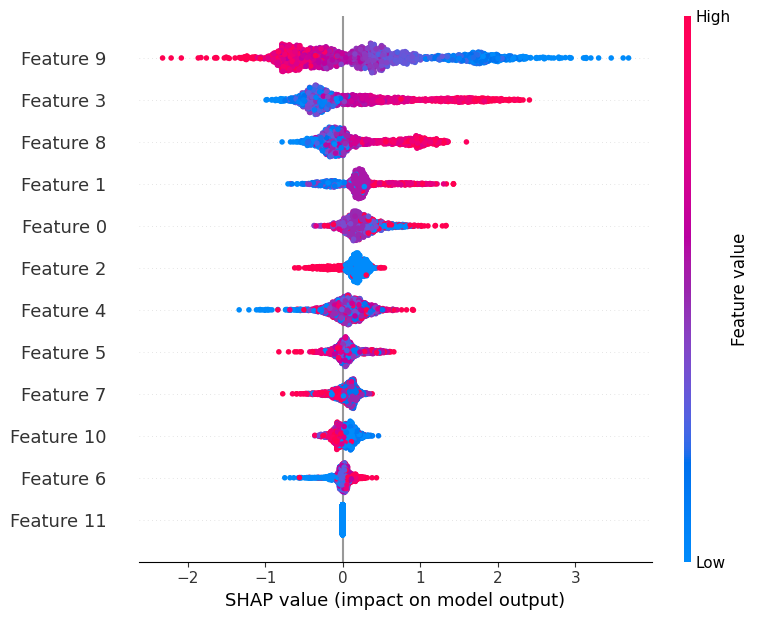

In [244]:
import shap
explainerx=shap.TreeExplainer(pipeline.named_steps["model"].named_estimators_["xgb"])
shap_valuesx=explainerx.shap_values(X_test_transformed)
shap.summary_plot(shap_valuesx,X_test_transformed)

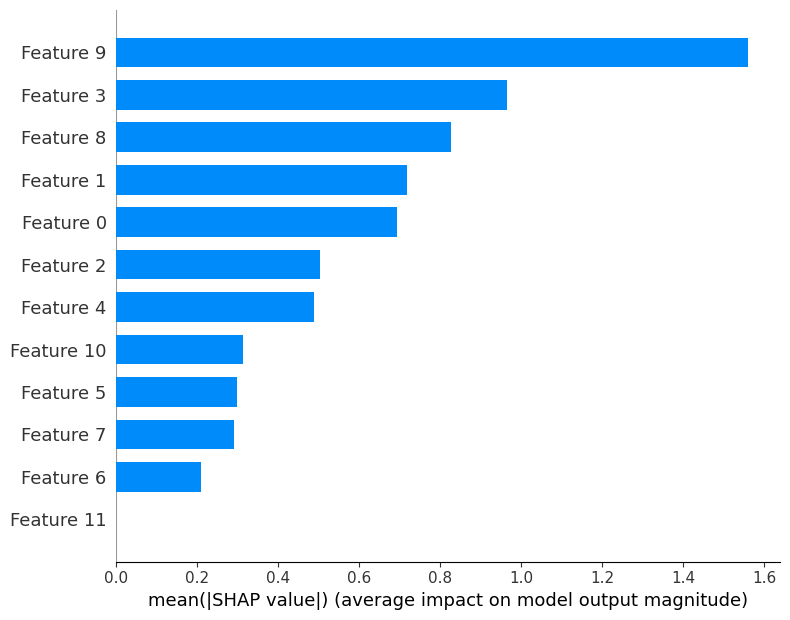

In [245]:
import shap
explainer=shap.TreeExplainer(pipeline.named_steps["model"].named_estimators_["cat"])
shap_values=explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values,X_test_transformed,plot_type="bar")

In [246]:
X_train["primary_genre_grouped"].unique()

array(['other', 'Personalization', 'Lifestyle', 'Communication',
       'Photography', 'Tools', 'Education', 'Action', 'Entertainment',
       'Productivity', 'Finance'], dtype=object)